In [1]:
import logging
from os import cpu_count

import numpy as np, pandas as pd
import sqlite3
import pymc as pm
import arviz as az

import matplotlib.pyplot as plt, seaborn as sns
plt.rcParams["figure.figsize"] = (28, 6)
plt.style.use("ggplot")

from bnn import construct_bnn, train_and_predict_bnn, pp_to_preds, pp_to_preds_stds

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

## Data Querying and Cleaning

We have the following tables:

In [2]:
conn = sqlite3.connect("soccer.db")
cursor = conn.cursor()

pd.read_sql("SELECT name FROM sqlite_schema WHERE type='table' ORDER BY name", conn)

,name
0,Country
1,League
2,Match
3,Player
4,Player_Attributes
5,Team
6,Team_Attributes
7,sqlite_sequence


We will look to model the relationship between the odds of a home team win from a specific betting shop, and various other constructed features from the database.

In [3]:
def construct_df(conn=conn):
    query = """
    SELECT DISTINCT

    m.home_team_goal > m.away_team_goal AS home_win, 

    m.B365H AS home_odds,

    pa_home_gk.gk_diving AS home_gk_skills,
    pa_away_gk.gk_diving AS away_gk_skills,
    pa_home_st.finishing AS home_st_skills,
    pa_away_st.finishing AS away_st_skills,

    ta_home.buildUpPlaySpeed AS home_buildUpPlaySpeed,
    ta_away.buildUpPlaySpeed AS away_buildUpPlaySpeed,
    ta_home.chanceCreationShooting AS home_chanceCreationShooting,
    ta_away.chanceCreationShooting AS away_chanceCreationShooting,
    ta_home.defencePressure AS home_defencePressure,
    ta_away.defencePressure AS away_defencePressure

    FROM Match m
    """

    player_attribute_suffix = """
    LEFT JOIN (
        SELECT *
        FROM Player_Attributes
        WHERE date = '2007-02-22 00:00:00'
    ) pa_{side}_{pos}
    ON pa_{side}_{pos}.player_api_id = m.{side}_player_{num}
    """
    positions, nums = ("gk", "st"), (1, 11)
    player_attribute_suffices = [player_attribute_suffix.format(side=side, pos=pos, num=num) for side in ("home", "away") for (pos, num) in zip(positions, nums)]

    team_attribute_suffix = """
    LEFT JOIN (
        SELECT *
        FROM Team_Attributes
        WHERE date = '2010-02-22 00:00:00'
    ) ta_{side}
    ON ta_{side}.team_api_id = m.{side}_team_api_id
    """
    team_attribute_suffices = [team_attribute_suffix.format(side=side) for side in ("home", "away")]
    
    query += " ".join(player_attribute_suffices).join(team_attribute_suffices)
    query += " WHERE m.date >= '2010-02-22 00:00:00'"

    return pd.read_sql(query, conn)

In [4]:
df = construct_df()
df.dropna(how="any", inplace=True)
df.head()

,home_win,home_odds,home_gk_skills,away_gk_skills,home_st_skills,away_st_skills,home_buildUpPlaySpeed,away_buildUpPlaySpeed,home_chanceCreationShooting,away_chanceCreationShooting,home_defencePressure,away_defencePressure
0,1,1.91,55.0,66.0,61.0,69.0,45.0,40.0,55.0,60.0,65.0,70.0
1,1,2.40,48.0,65.0,61.0,61.0,40.0,60.0,60.0,50.0,70.0,65.0
2,0,3.75,60.0,56.0,54.0,66.0,65.0,45.0,40.0,60.0,65.0,70.0
3,0,6.50,48.0,74.0,61.0,61.0,40.0,50.0,60.0,60.0,70.0,70.0
4,1,2.10,55.0,65.0,62.0,47.0,45.0,60.0,55.0,50.0,65.0,65.0


In [5]:
df.shape

(14314, 12)

We will predict the probability of a home win implied by the `home_odds` feature.

In [6]:
def transform_targets(odds):
    return np.log(odds - 1)

In [7]:
TARGET_NAME = "targets"
df[TARGET_NAME] = transform_targets(df["home_odds"])
FEATURE_NAMES = df.columns.drop([TARGET_NAME, "home_win", "home_odds"])

<AxesSubplot: >

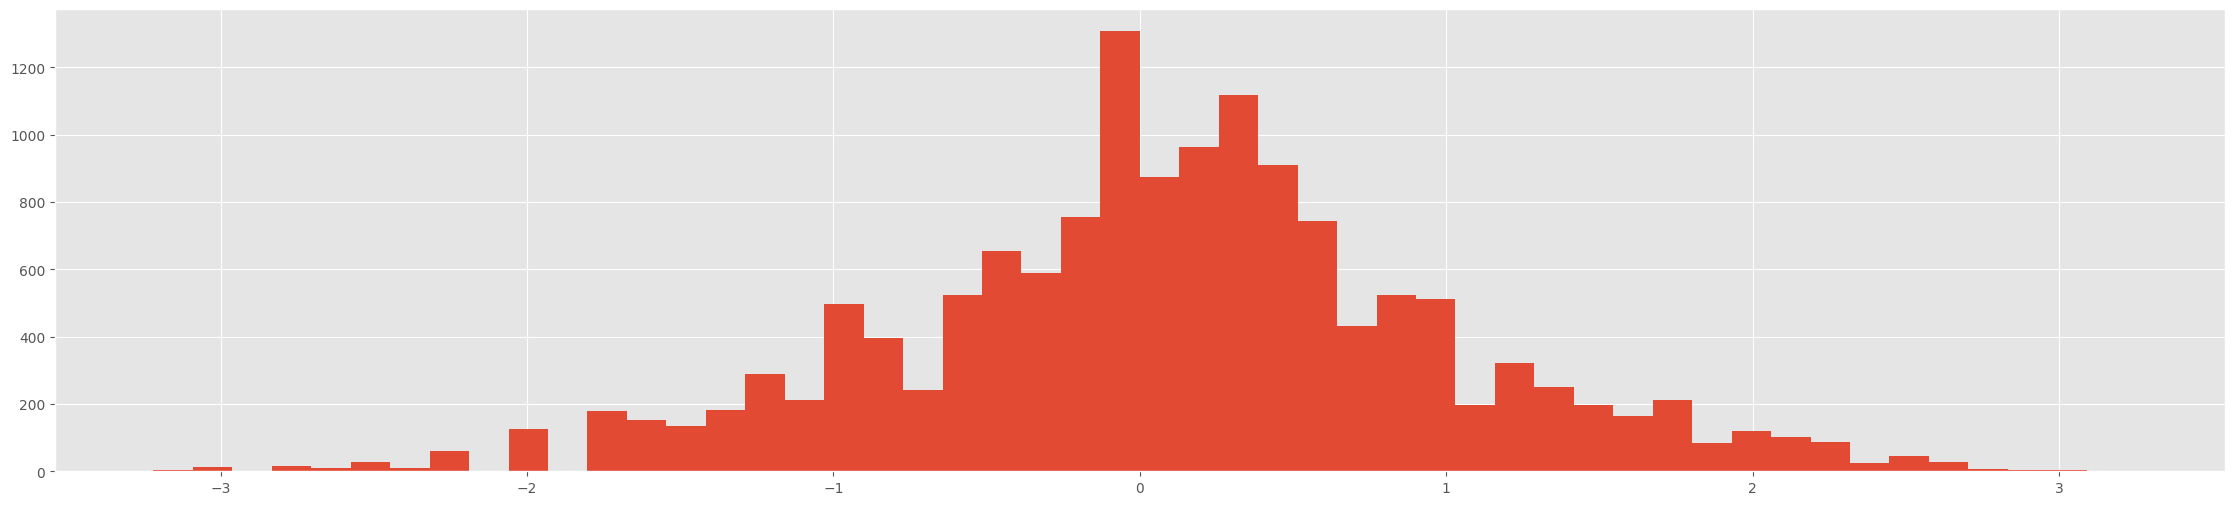

In [8]:
df["targets"].hist(bins=50)

A normal distribution seems a reasonable assumption for these transformed targets.

In [9]:
# model variables
LAYERS = (len(FEATURE_NAMES), 20, 1)

# train-test split variables
TEST_PROP = 0.3

# Bayesian computation variables
ADVI_ITER = 50000
TRACE_DRAWS = 5000

In [10]:
def train_test_split(df, feature_names=FEATURE_NAMES, target_name=TARGET_NAME, test_prop=TEST_PROP):
    break_idx = - int(test_prop * len(df))
    train_idx, test_idx = df.index[:break_idx], df.index[break_idx:]
    return (
        df.loc[train_idx, feature_names], 
        df.loc[train_idx, target_name],
        df.loc[test_idx, feature_names],
        df.loc[test_idx, target_name],
    )

Construct the train-test split:

In [11]:
X_train, y_train, X_test, y_test = train_test_split(df)

Now construct and visualise the model:

In [12]:
model = construct_bnn(
    X_train,
    y_train,
    layers=LAYERS, 
    hidden_activ_func=pm.math.tanh,
)

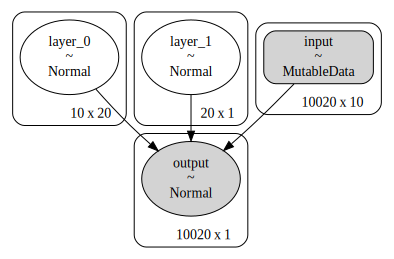

In [13]:
pm.model_to_graphviz(model)

Now fit the model (we use ADVI as opposed to NUTS sampling because due to computational advantages of ADVI):

In [14]:
trace, train_pp, test_pp, advi = train_and_predict_bnn(
    model, 
    X_test,
    advi_iter=ADVI_ITER, 
    trace_draws=TRACE_DRAWS, 
)

Finished [100%]: Average Loss = 13,081
INFO:pymc.variational.inference:Finished [100%]: Average Loss = 13,081
Sampling: [output]
INFO:pymc:Sampling: [output]


Sampling: [output]
INFO:pymc:Sampling: [output]


In [15]:
train_preds = pp_to_preds(train_pp)
test_preds = pp_to_preds(test_pp)

We can evaluate the train and test set predictions by looking at the correlations:

In [16]:
np.corrcoef(train_preds, y_train)[0, 1]

0.17573783549545302

In [17]:
np.corrcoef(test_preds, y_test)[0, 1]

0.19595706767580193

It is encouraging that there is positive correlation between our predictions and the targets, and also that there is no sign of overfitting here. Below we see how the variational inference algorithm increases the ELBO over time:

Text(0.5, 0, 'Iteration')

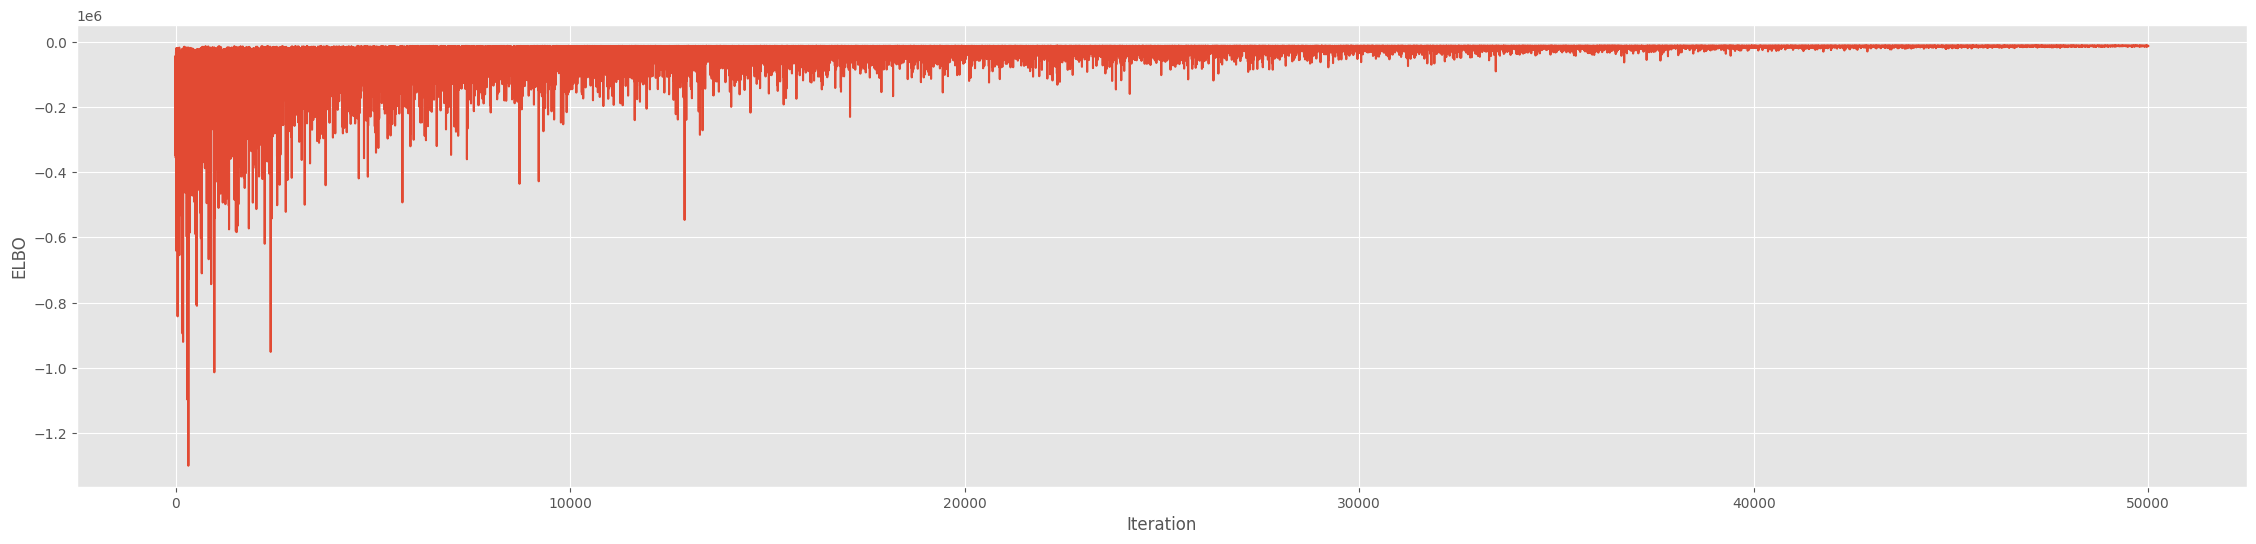

In [18]:
plt.plot(-advi.hist)
plt.ylabel("ELBO")
plt.xlabel("Iteration")

We can plot KDEs for the posterior distributions directly (see left), and also the sampled points over time for each chain (see right). It is somewhat clear that the samples quickly converge to the target (variational) posterior:

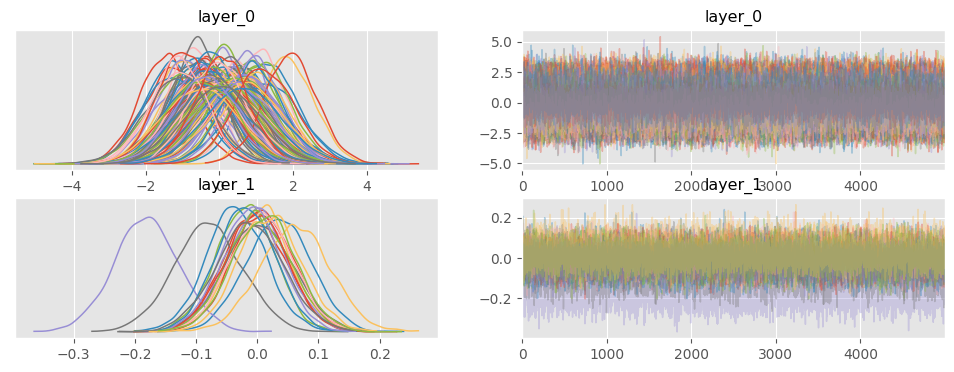

In [23]:
_ = pm.plot_trace(trace)

We can also plot the ACFs for each parameter (e.g. for layer 1 shown below). We expect no autocorrelation once the MCMC algorithm has converged to its target distribution.

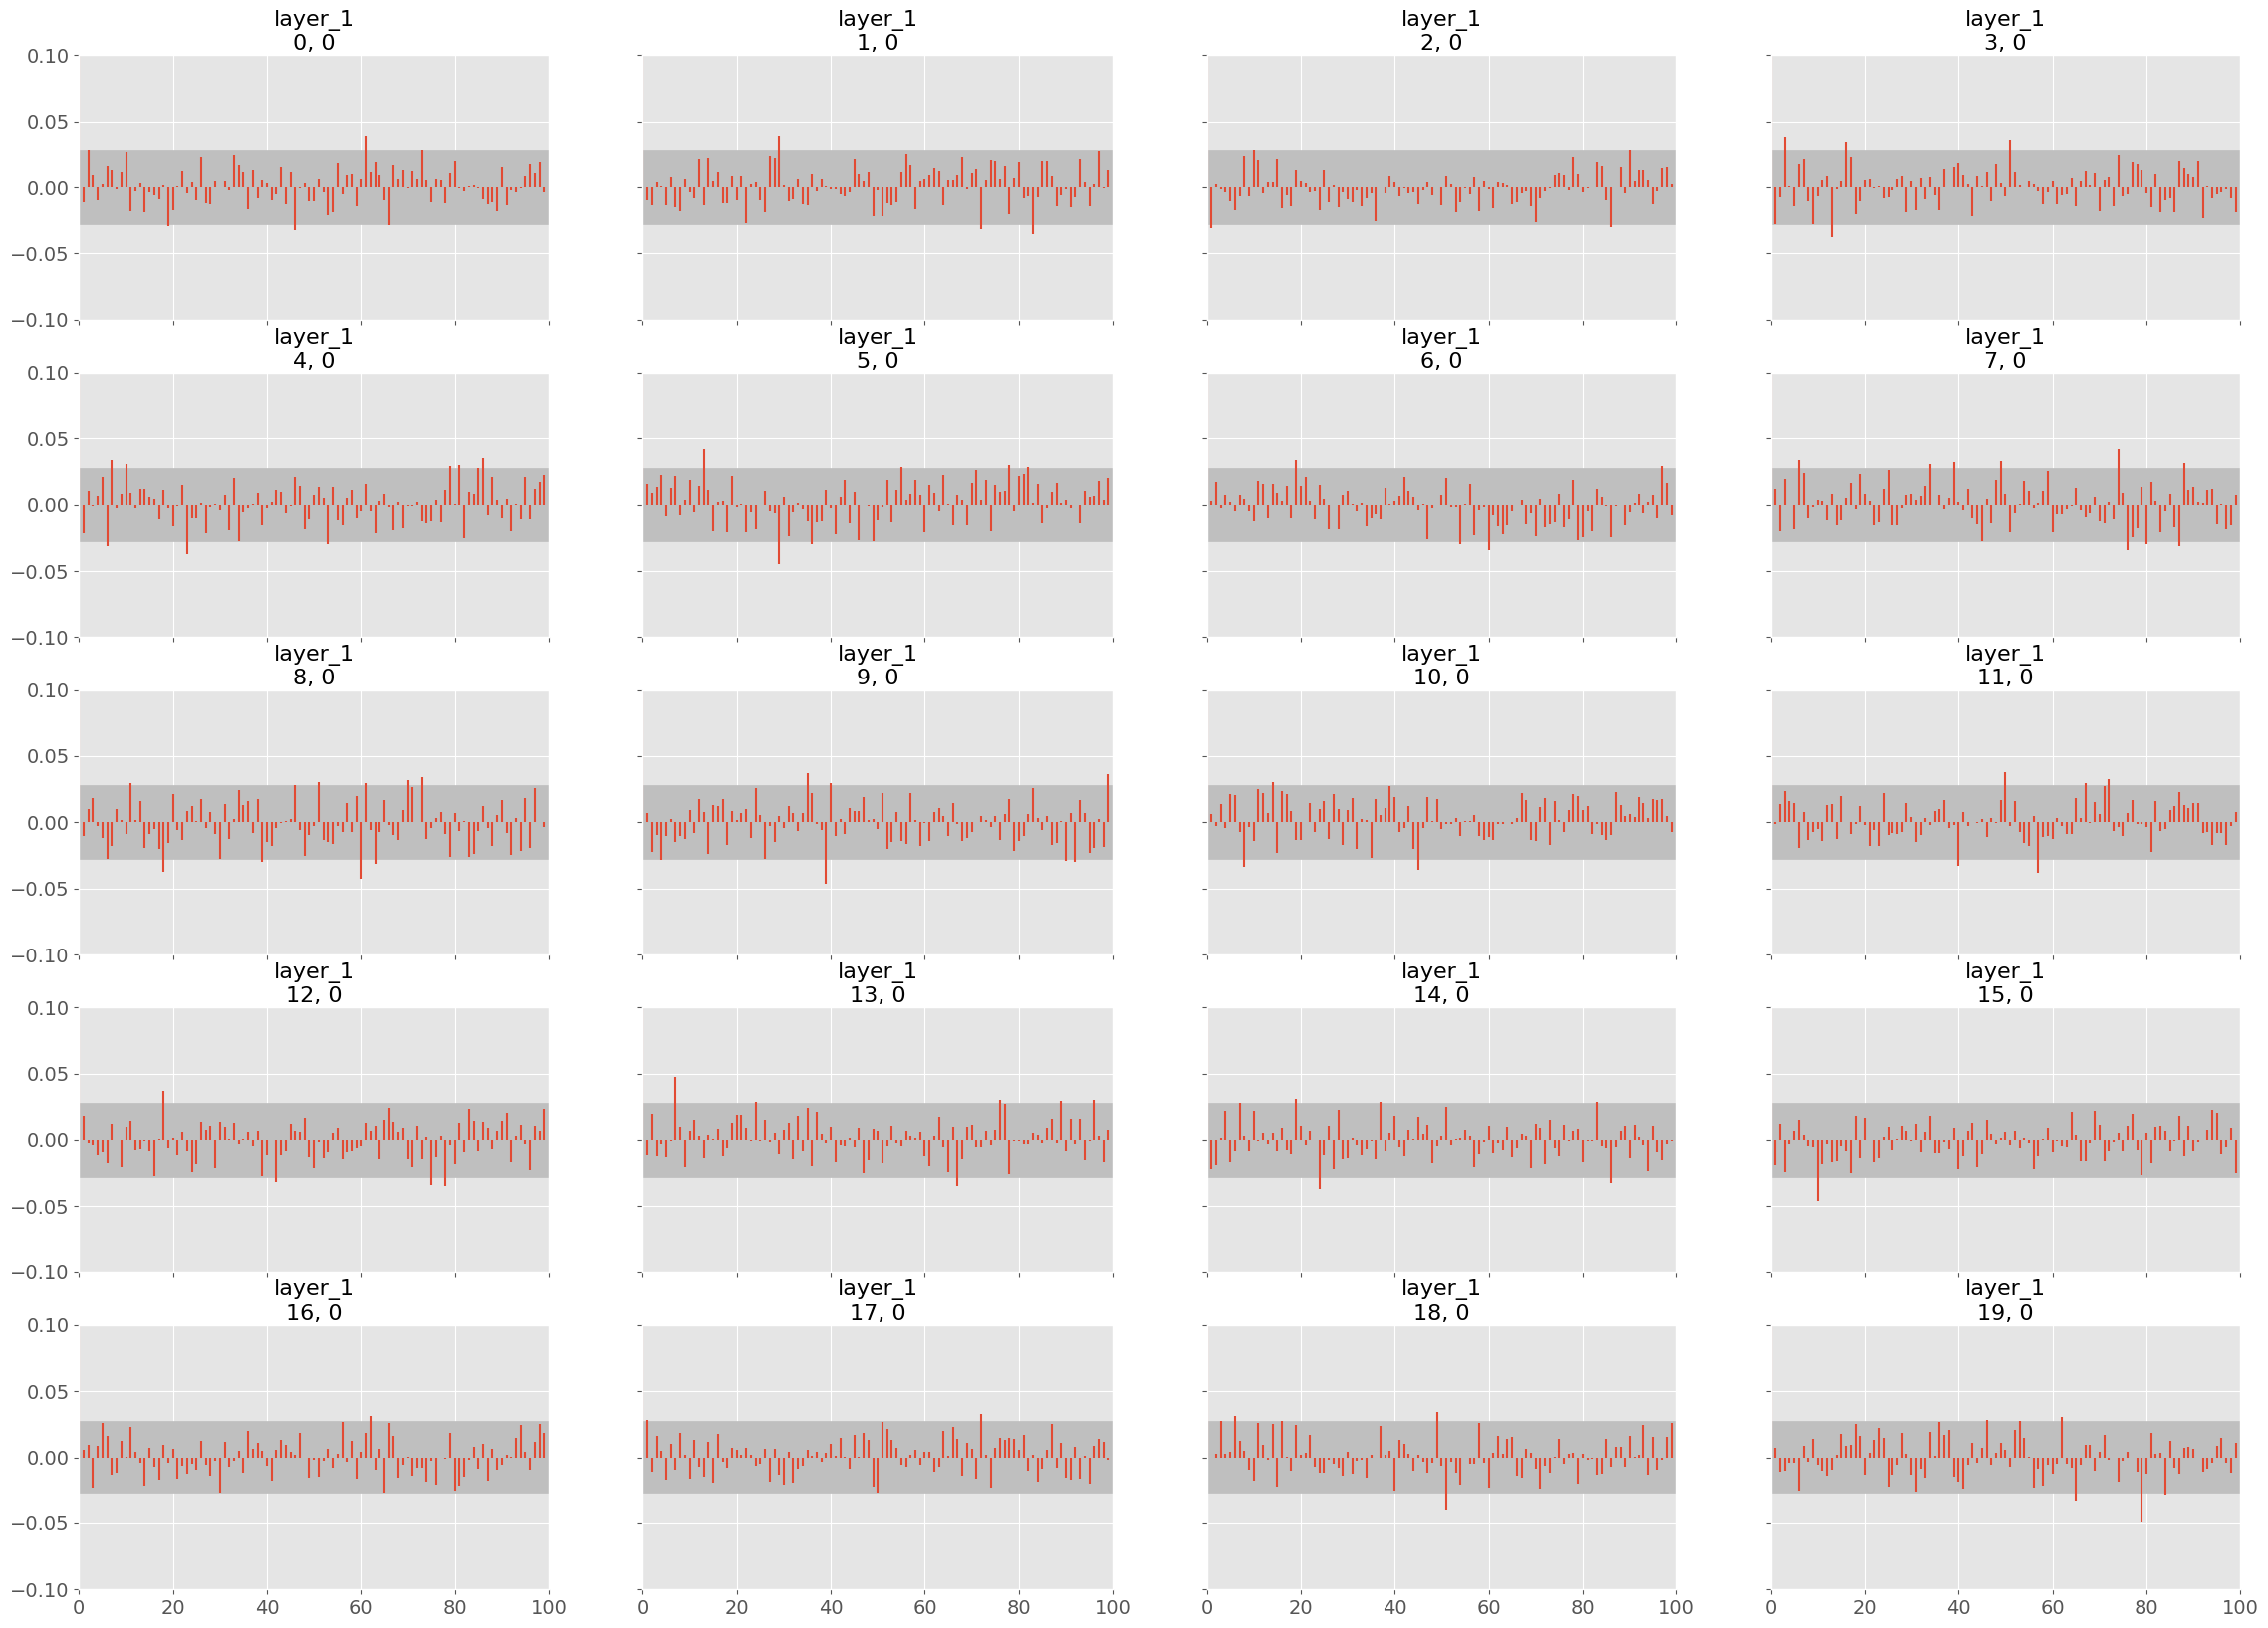

In [28]:
axs = pm.plot_autocorr(trace, var_names="layer_1", combined=True, figsize=(28, 20))
for ax in axs.ravel():
    ax.set_ylim(-0.1, 0.1)

Thankfully there is little sign of autocorrelation. We can also look at the effective sample size of the trace:

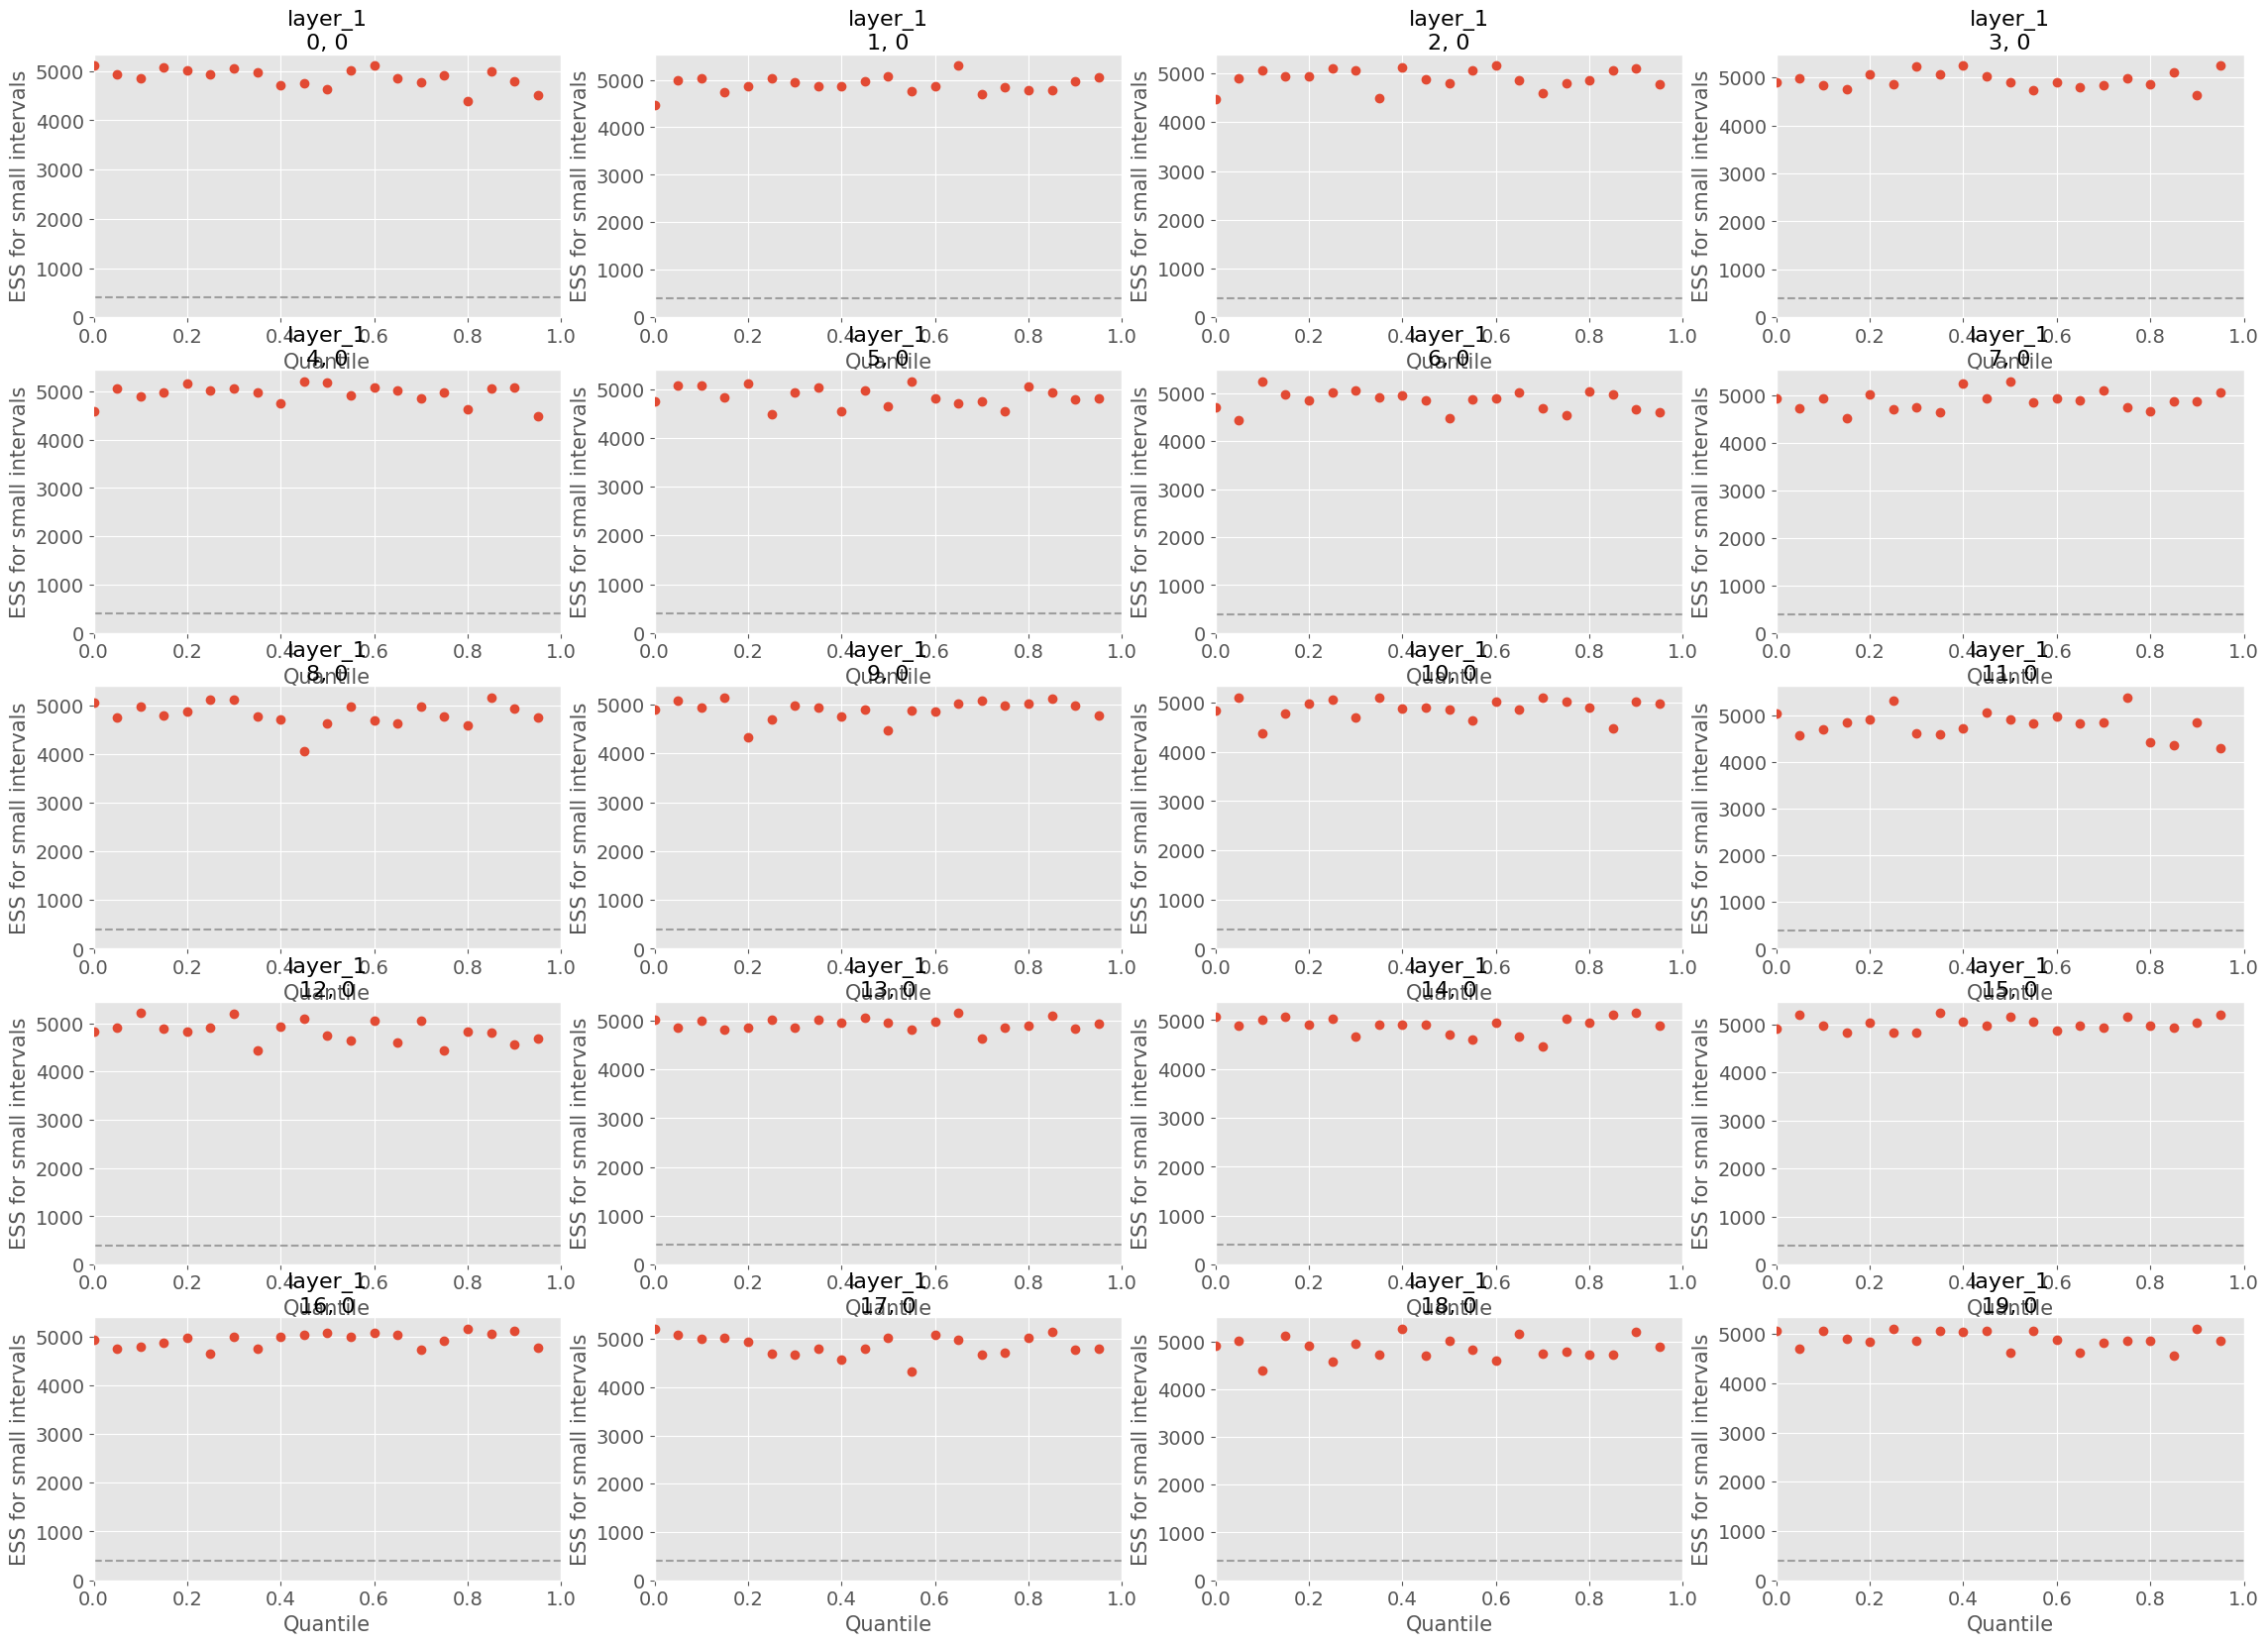

In [31]:
_ = pm.plot_ess(trace, var_names="layer_1", kind="local", figsize=(28, 20))

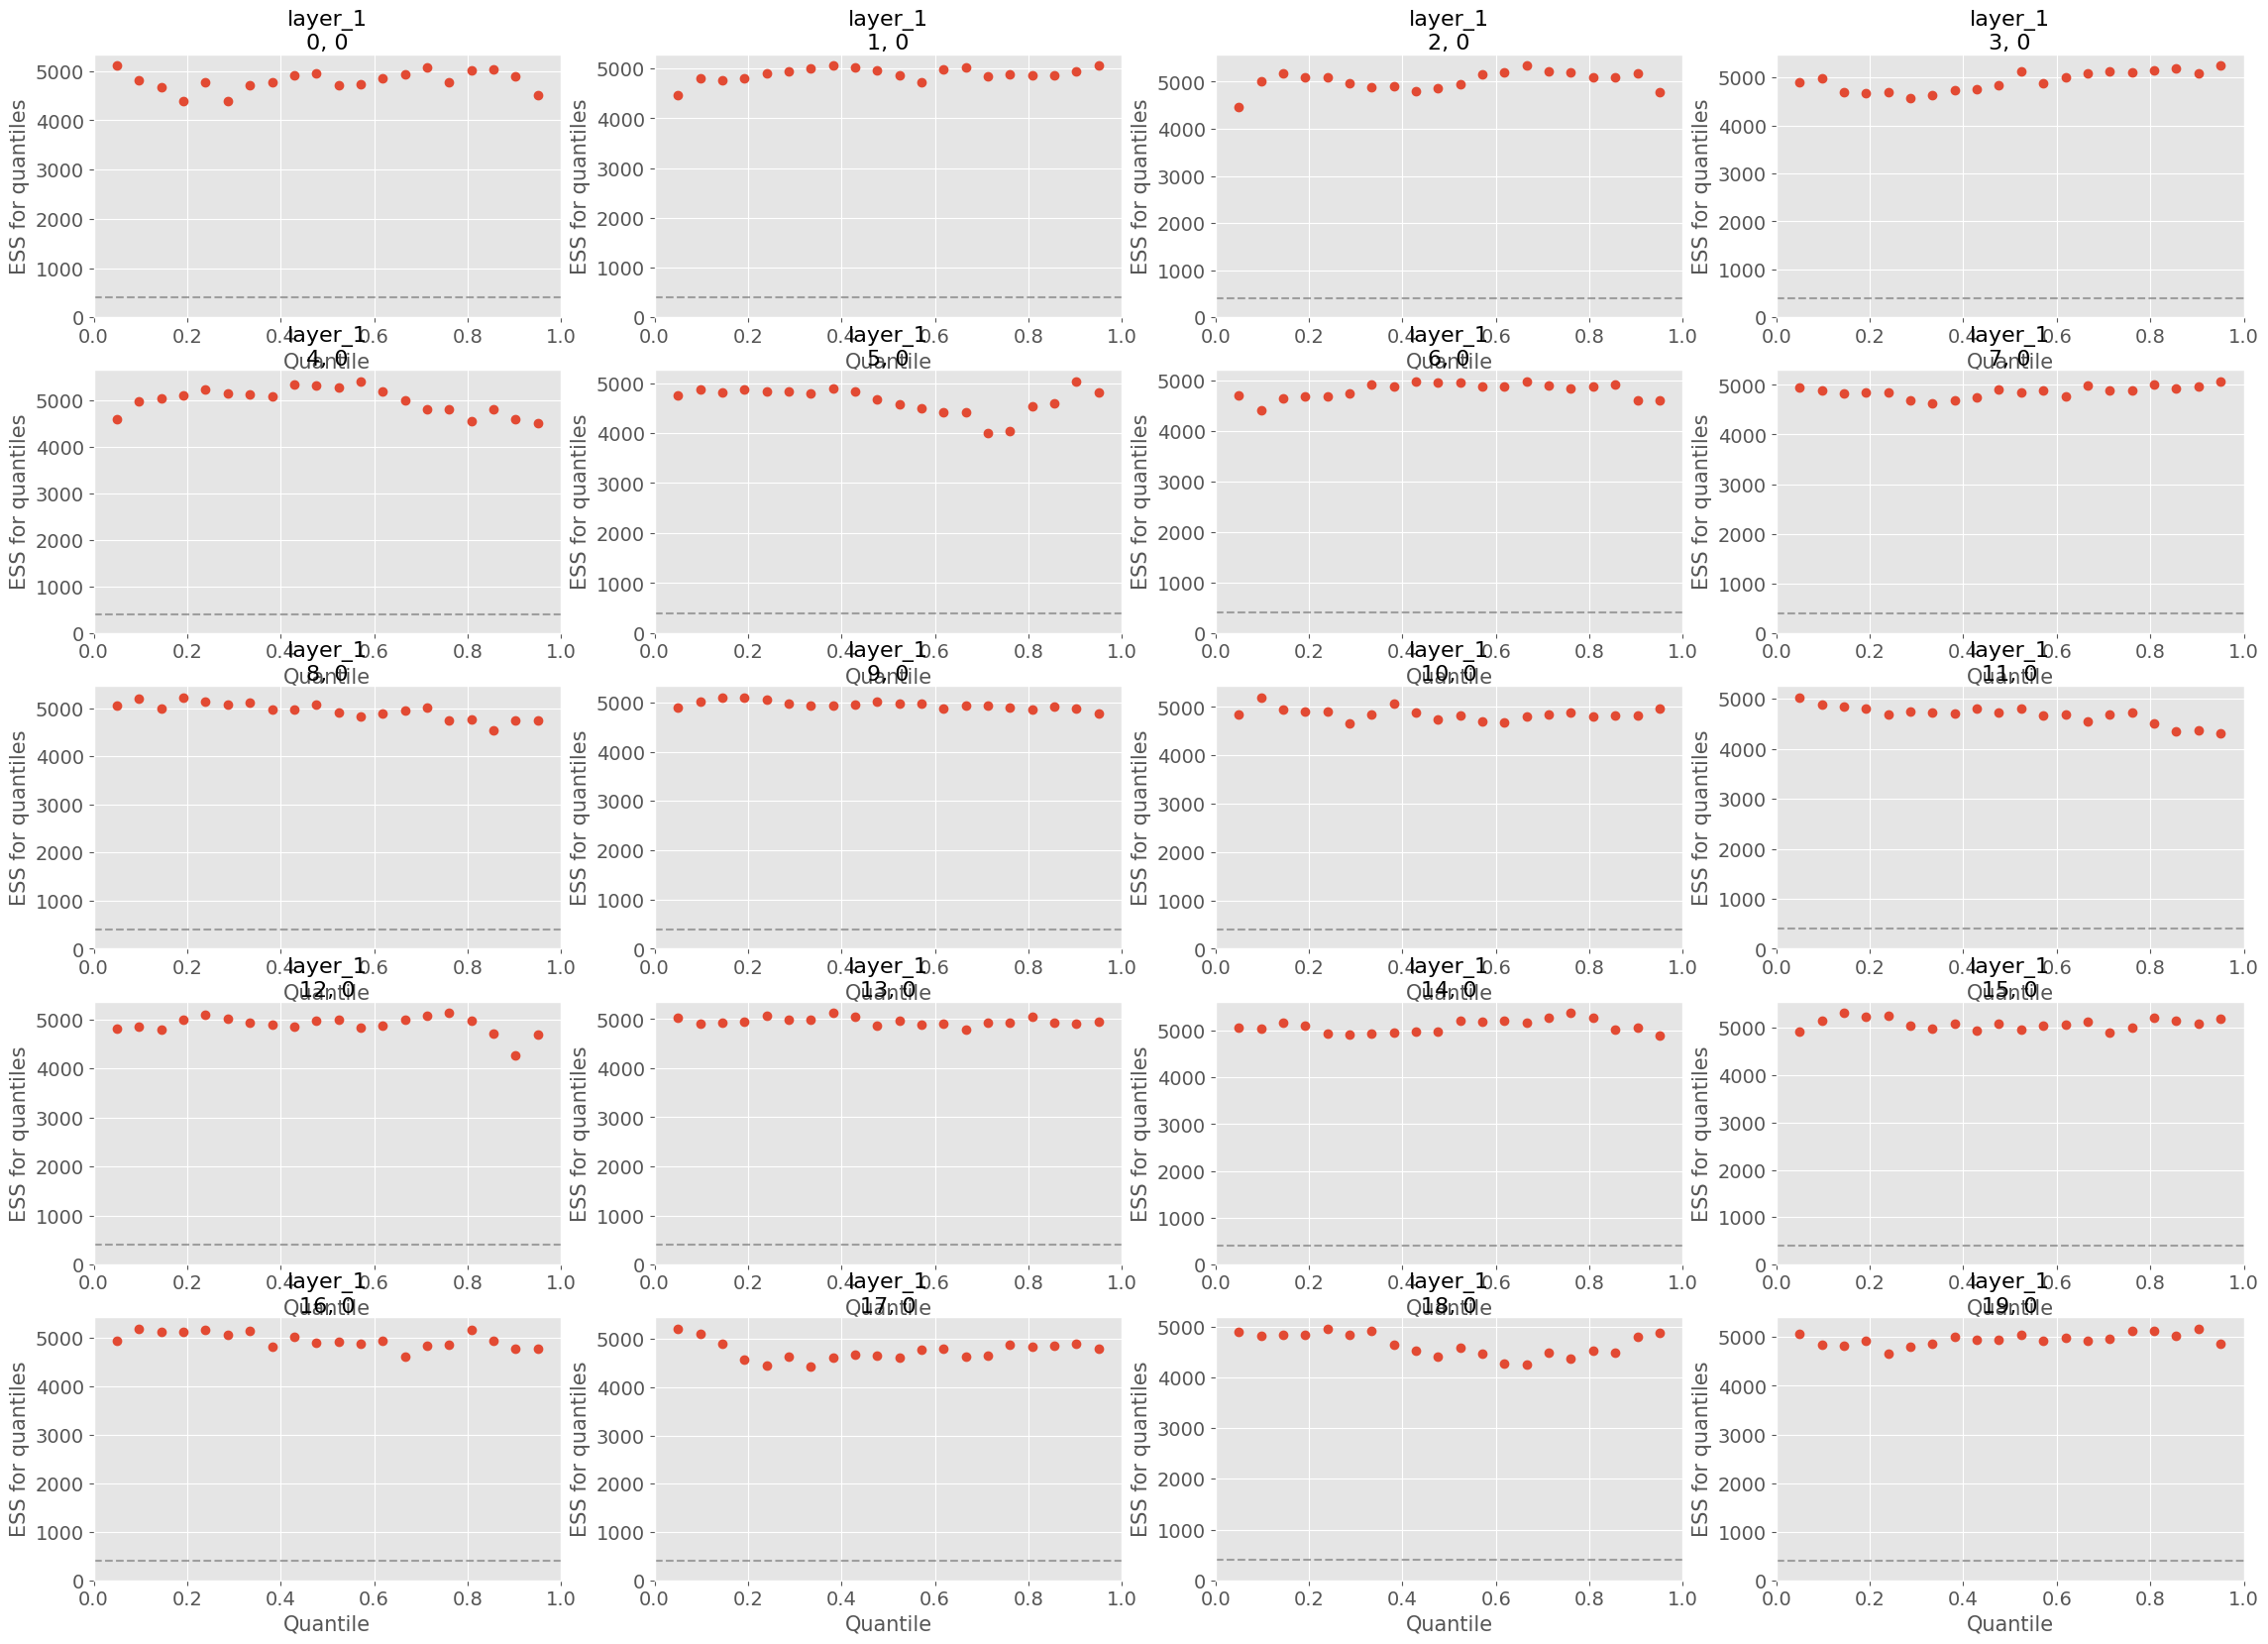

In [32]:
_ = pm.plot_ess(trace, var_names="layer_1", kind="quantile", figsize=(28, 20))

We see that the ESS hovers around 5000, our sample size, and is consistent across the parameter space, so this looks good. Finally we can look at the Monte Carlo Standard Error, though does not always have an obvious baseline/reference point:

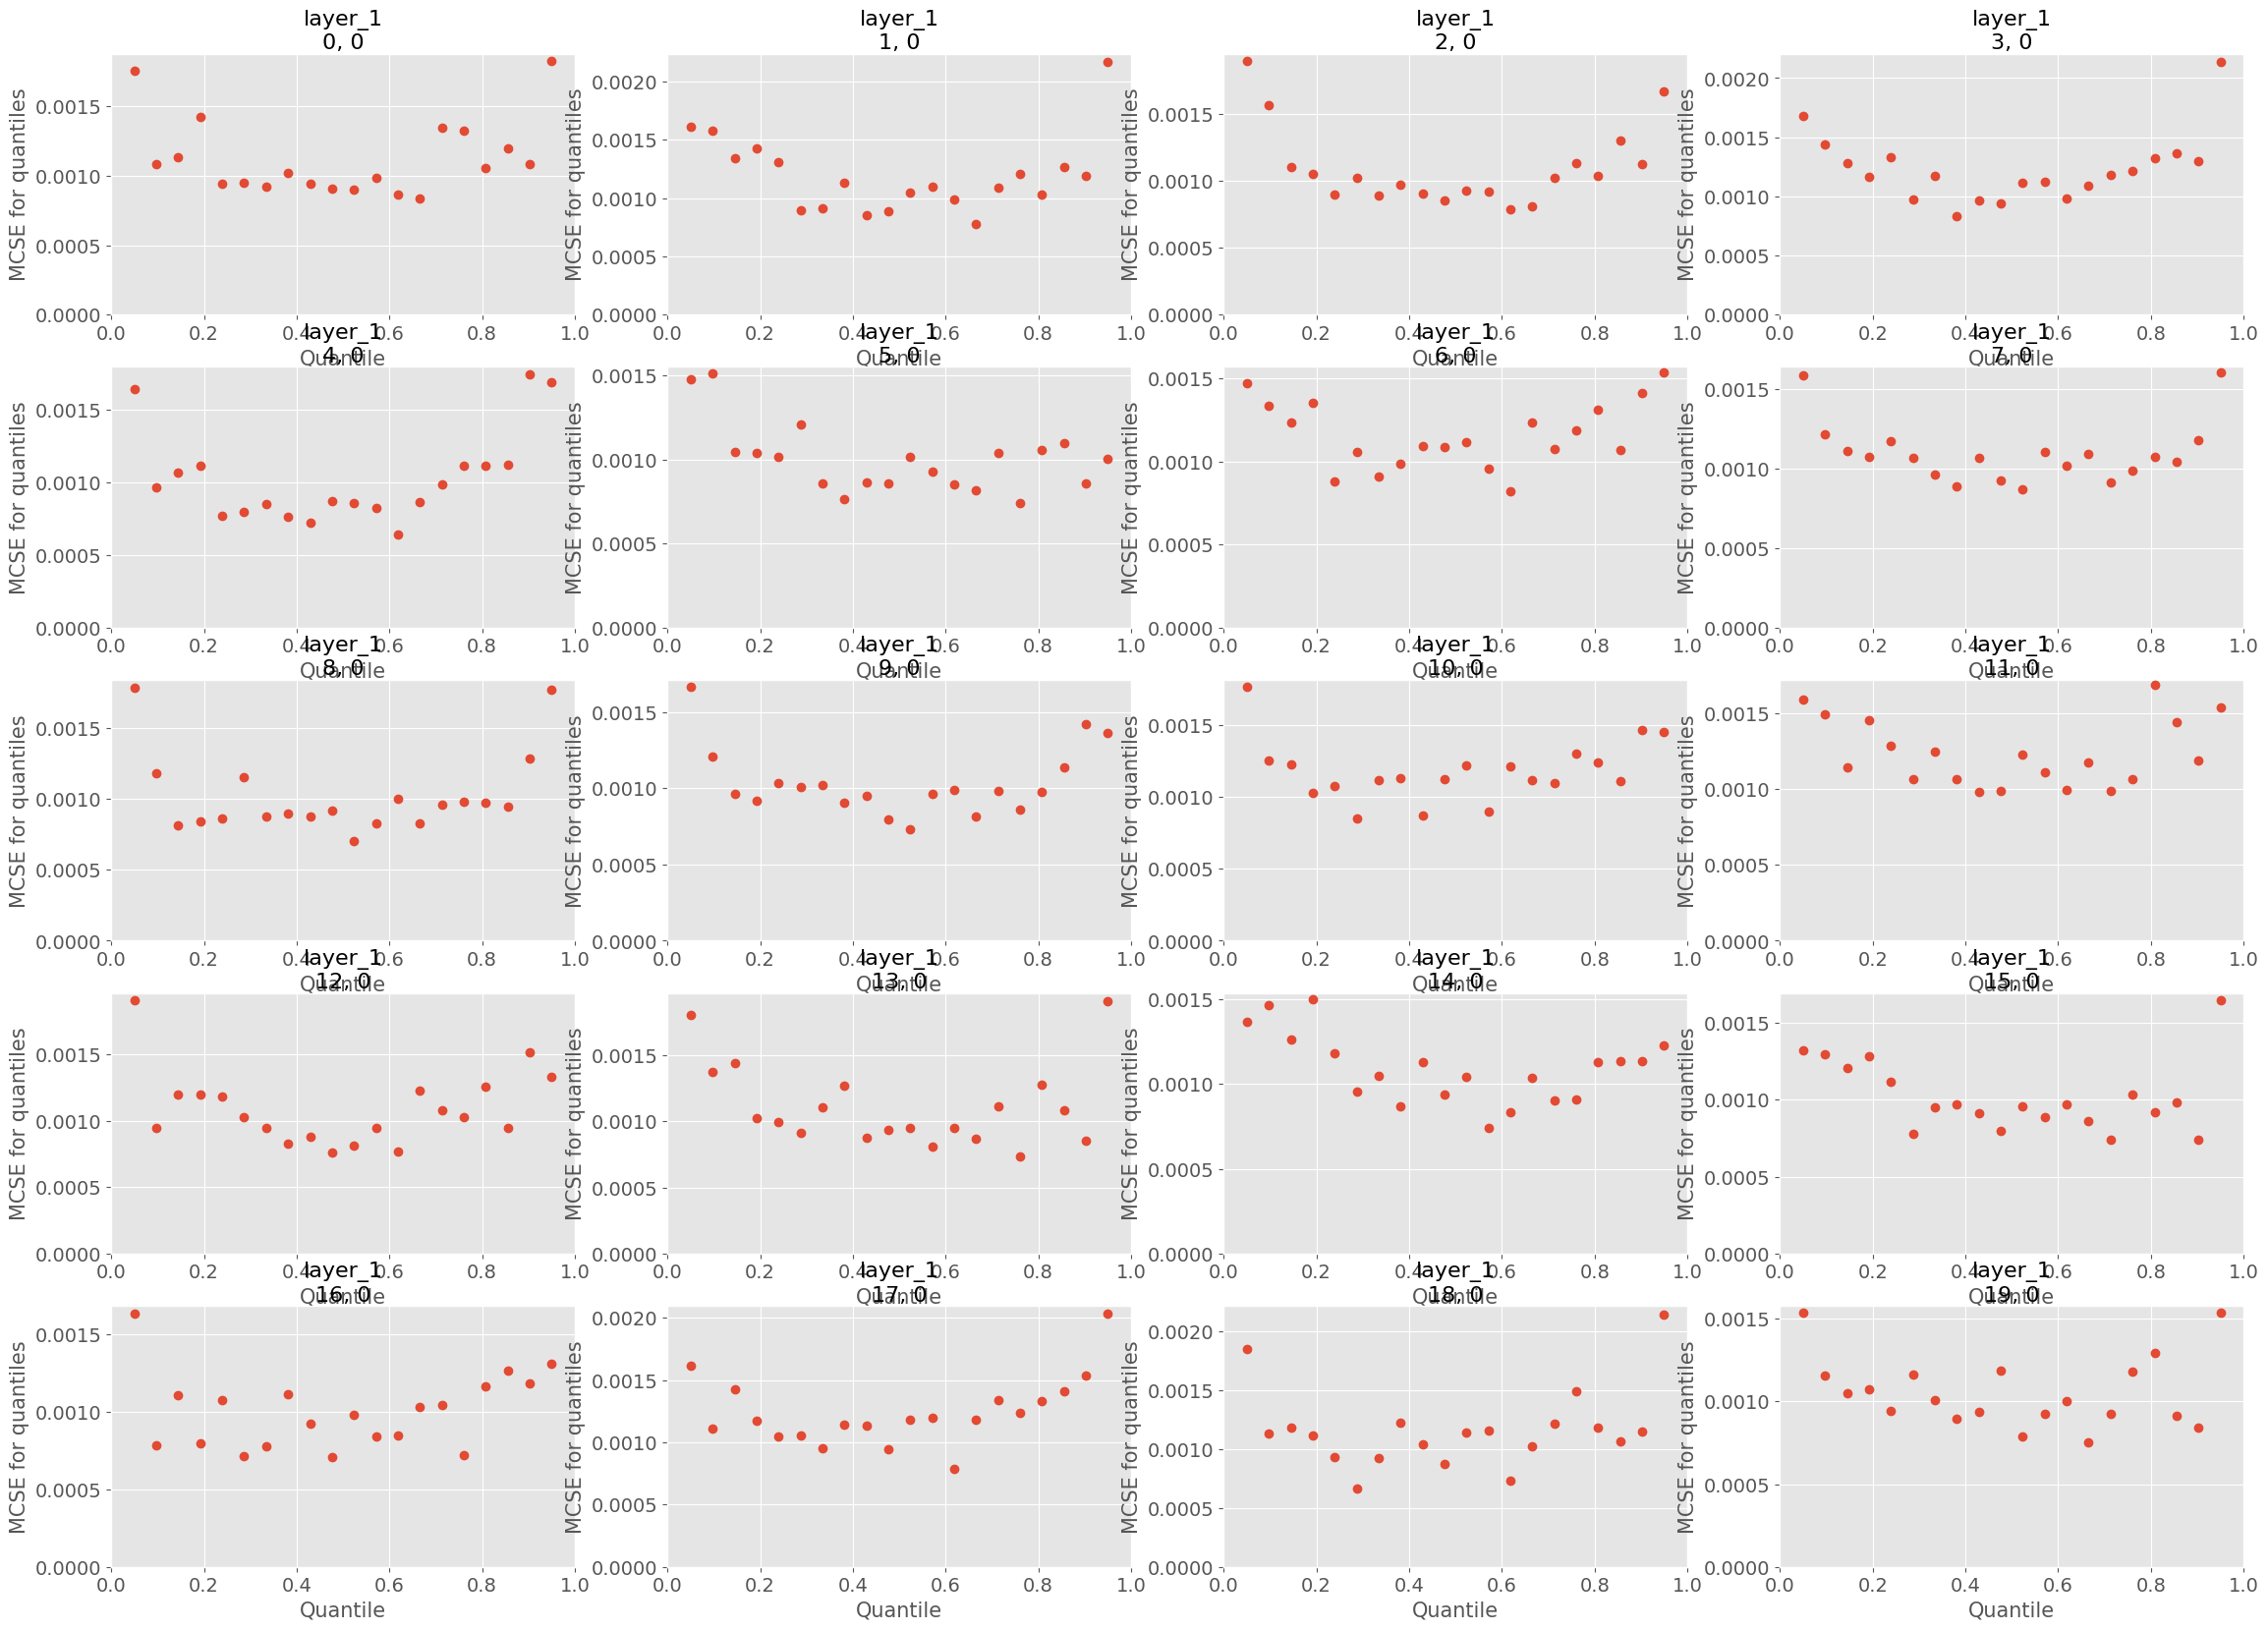

In [35]:
_ = pm.plot_mcse(trace, var_names="layer_1", figsize=(28, 20))

We now look at a few posterior predictive check plots.

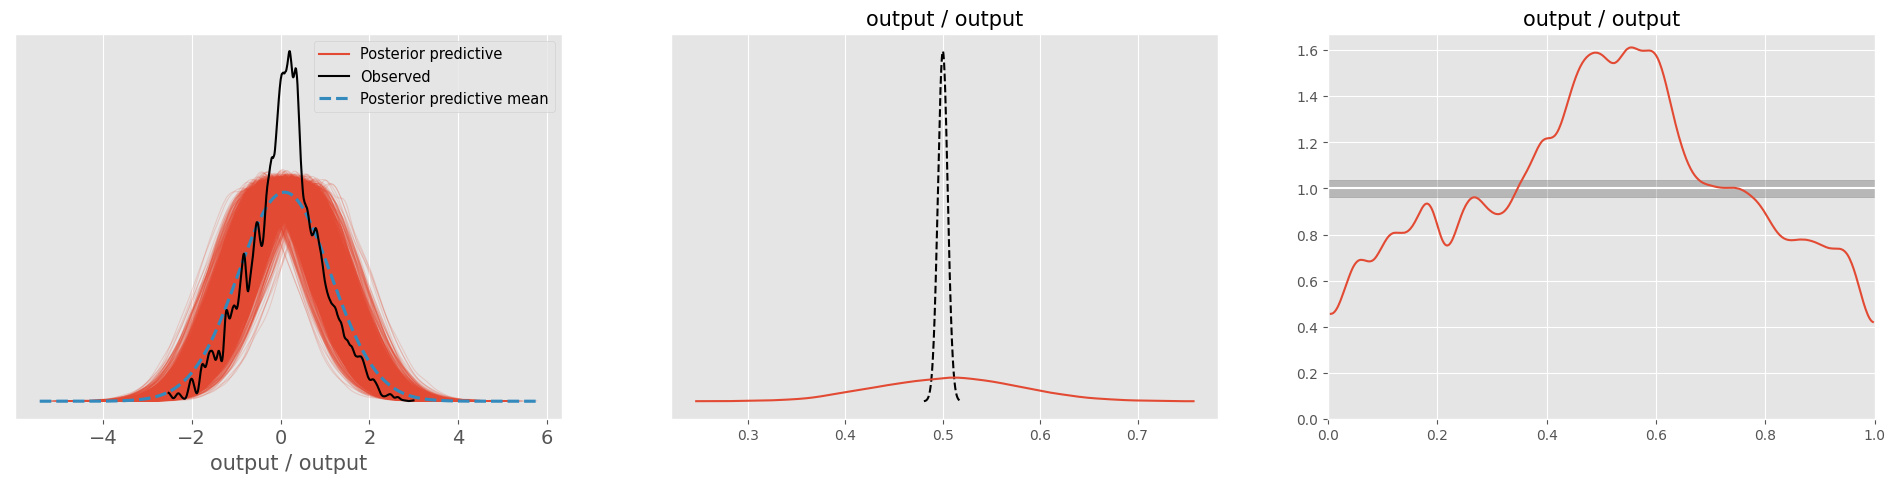

In [30]:
fig, ax = plt.subplots(1, 3, figsize=(24, 5))
_ = pm.plot_ppc(train_pp, ax=ax[0])
_ = pm.plot_bpv(train_pp, kind="p_value", ax=ax[1])
_ = pm.plot_bpv(train_pp, kind="u_value", ax=ax[2])

On the left, we compare the observed distribution with the posterior predictive. This isn't terrible, but we see that the model is making predictions that are slightly more spread than the observed data. 

In the middle, the solid line is the KDE of the proportion of predictions less than equal to the observed data, while the dashed line represents the expected distribution for a dataset of the same size as the observed data.

The right plot confirms what we saw in the first plot: the model is making fewer predictions in the middle, and too many at the tails. This suggests that maybe the normality assumption is not valid.

Under our Bayesian neural network model, we can use the ratio between predictions and their standard deviations across different samples from the trace as a combined quantification of our prediction and our confidence in that prediction. This could be used, for example, in a stat-arb-like strategy, where we look for major departures of our scores vs the existing odds, and place bets accordingly.

In [ ]:
test_preds_stds = pp_to_preds_stds(test_pp)
test_preds / test_preds_stds